In [1]:
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
from random import randint, random, uniform

In [27]:
def ray_tracing_numpy(x,y,poly):
    n = len(poly)
    inside = np.zeros(len(x),np.bool_)
    p2x = 0.0
    p2y = 0.0
    xints = 0.0
    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        idx = np.nonzero((y > min(p1y,p2y)) & (y <= max(p1y,p2y)) & (x <= max(p1x,p2x)))[0]
        if p1y != p2y:
            xints = (y[idx]-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
        if p1x == p2x:
            inside[idx] = ~inside[idx]
        else:
            idxx = idx[x[idx] <= xints]
            inside[idxx] = ~inside[idxx]    

        p1x,p1y = p2x,p2y
    return inside  

In [134]:
def reflect(gen, bdPts):
    """reflect all points across the line that goes through p1 and p2
    
    @param  points - (list[list[real]]) each element is of the form [x, y]
    @param  p1 - (list[real]) point in R2
    @param  p2 - (list[real]) point in R2, distinct from p1
    @return (list[list[real]]) reflected points
    """
    N = len(gen);
    m = len(bdPts);
    #firt loop boundary back around
    bdPts = np.vstack( [bdPts, bdPts[0,:]] )
    
    #Below should be approx the number of boundary nodes at each Add nodes on the boundary
    bdN = np.ceil(0.5*np.sqrt(N));#maybe +1
    h = 1.0/bdN;
    lambdaLS = np.linspace(h,1-h,int(bdN-1))# going to use barycentric weights for boundary edge
    N_lambda = len(lambdaLS)
    fill = np.zeros([int(m*(bdN - 1)),2])
    allNode = np.vstack( [gen, np.zeros([int(m*(bdN-1)),2]), bdPts[0:m,:]] )
    bigN = len(allNode);
    isBdAddNode = np.zeros([bigN,m], dtype=bool)
    tempNode = np.zeros([N_lambda,2])
    for i in range(m):
        tempNode[:,0] = (1-lambdaLS)*bdPts[i,0]+lambdaLS*bdPts[i+1,0]; 
        tempNode[:,1] = (1-lambdaLS)*bdPts[i,1]+lambdaLS*bdPts[i+1,1];
        leftN = int(N+(i)*(bdN-1))
        rightN = int(N+(i+1)*(bdN-1))
        allNode[leftN:rightN,:] = tempNode
        isBdAddNode[leftN:rightN,i] = True;
        if i < m-1:
            leftN = int(N+m*(bdN-1)+i)
            rightN = int(N+m*(bdN-1)+i+2)
            isBdAddNode[leftN:rightN,i] = True;
        else:
            leftN = int(N+m*(bdN-1)+i)
            rightN = int(N+m*(bdN-1)+2)
            isBdAddNode[leftN:rightN,i] = True;
    
    tri = Delaunay(allNode)
    elem = tri.simplices
    
    #for debugging
    #plt.triplot(allNode[:,0], allNode[:,1], tri.simplices)
    #plt.plot(allNode[:,0], allNode[:,1], 'o')
    #plt.show()
    elemN = len(elem)
    isRefNode = np.zeros([bigN,m], dtype=bool)
    for i in range(m):
        #Create logical arrays for identifying connectivity
        isNearBdNode = np.zeros([bigN,1], dtype=bool);        
        isBdElem = isBdAddNode[elem[:,0],i] + isBdAddNode[elem[:,1],i] + isBdAddNode[elem[:,2],i]
        isNearBdNode[elem[isBdElem,:]] = True;
        #Find nodes near boundary
        isBdElem = isNearBdNode[elem[:,0]] + isNearBdNode[elem[:,1]] + isNearBdNode[elem[:,2]]
        elemN = len(elem[isBdElem[:,0],:])
        maskRefNode = np.unique(np.reshape(elem[isBdElem[:,0],:],(elemN*3,1)))
        isRefNode[maskRefNode,i] = True
        isRefNode[N+1:bigN,i] = False
        
    isRefNode = isRefNode[0:N,:]
    ###Reflect generators for each boundary segment
    allNode = np.zeros([4*N,2])
    allNode[0:N,:] = gen
    switchPair = np.zeros([100,2])
    sN = 0
    currentN = N
    for i in range(m):
        # reflection of near boundary nodes
        r2 = np.sqrt((bdPts[i+1,0] - bdPts[i,0])**2 + (bdPts[i+1,1] - bdPts[i,1])**2)
        costheta = (bdPts[i+1,0] - bdPts[i,0])/r2
        sintheta = (bdPts[i+1,1] - bdPts[i,1])/r2
        maskRefNode = np.array(isRefNode[:,i]).astype(np.bool)
        #tempMatMulti = np.reshape(np.vstack([gen[maskRefNode,0] - bdPts[i,0],gen[maskRefNode,1] - bdPts[i,1]]),[len(gen[maskRefNode,0]),2])
        tempMatMulti = np.transpose(np.vstack([gen[maskRefNode,0] - bdPts[i,0],gen[maskRefNode,1] - bdPts[i,1]]))
        #rotate to y axis
        tempNode = np.matmul(tempMatMulti,[[costheta, -sintheta],[sintheta, costheta]])
        #reflect over to y axis
        tempNode[:,1] = -tempNode[:,1]
        #inverse rotation
        tempNode = np.matmul(tempNode,[[costheta, sintheta],[-sintheta, costheta]])
        #refNode = np.reshape(np.vstack([tempNode[:,0] + bdPts[i,0], tempNode[:,1] + bdPts[i,1]]),[len(tempNode),2])
        refNode = np.transpose(np.vstack([tempNode[:,0] + bdPts[i,0], tempNode[:,1] + bdPts[i,1]]))
        addN =  np.size(refNode,0)
        #append reflective points
        refNodeRange = currentN + np.arange(addN)
        allNode[refNodeRange,:] = refNode;
        currentN = currentN + addN
        #record generators outside of the domain with their reflection
        inLogic = ray_tracing_numpy(gen[isRefNode[:,i],0],gen[isRefNode[:,i],1],bdPts[:m])
        if (sum(inLogic) != len(inLogic)):
            inRef = ray_tracing_numpy(refNode[not inLogic,0],refNode[not inLogic,1],bdPts[:m])
            # something went wrong, need to add below to switch the reflection with the generator (nonconvex)
            if (sum(inRef) != len(inRef)):
                #switchPair[sN + np.arange(sum(inRef)),:] = [refNodeIdx(out(inRef)) refNodeRange(out(inRef))];
                sN = sN + sum(inRef)
                
    allNode = allNode[:currentN,:]
    allTri = Delaunay(allNode)
    allElem =  allTri.simplices
    #for debugging
    plt.triplot(allNode[:,0], allNode[:,1], allTri.simplices)
    plt.plot(allNode[:,0], allNode[:,1], 'o')
    plt.show()
    
    #find circumcenter
    ax = allNode[allElem[:,0],0]
    ay = allNode[allElem[:,0],1]
    bx = allNode[allElem[:,1],0]
    by = allNode[allElem[:,1],1]
    cx = allNode[allElem[:,2],0]
    cy = allNode[allElem[:,2],1]
    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    ux = ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    uy = ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    
    # Construct Voronoi nodes
    vorNode = np.reshape(np.hstack([ux, uy]),[len(ux),2])
    # construct a Voronoi grid using all nodes and centers of triangles (vorNodes)
    vorTri = Delaunay(vorNode) #need to truncate this using the boundary and give the correct ordering
    vorElem =  vorTri.simplices #to construct the Voronoi cells from the triangulation

    #for debugging
    plt.triplot(vorNode[:,0], vorNode[:,1], vorTri.simplices)
    plt.plot(vorNode[:,0], vorNode[:,1], 'o')
    plt.show()
    
    return vorNode, vorElem

-1.0 0.0
0.0 -1.0
1.0 0.0
0.0 1.0


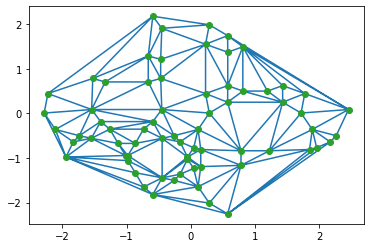

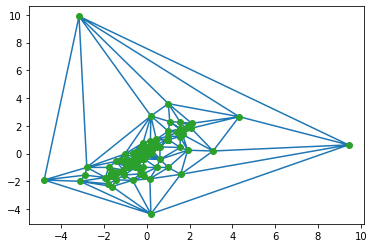

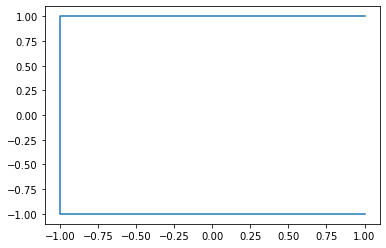

In [135]:
#test reflect nodes
domain = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]])
n = 20
#generators = [[uniform(-0.9, 0.9), uniform(-0.9, 0.9)] for _ in range(n)]
generators = 2*np.random.rand(n, 2) - 1
reflectPts = reflect(generators, domain)
plt.plot(domain[:,0], domain[:,1])

In [57]:
def reformat_cells(cells: list, generators: list) -> list:
    """reformat 'cells' into a format compatible with other functions
    
    @param  cells - (?) cells given by voronoi()
    @return (list[list[list[real]]]) list of cells; 
            each cell consists of a list of triangles; 
            each triangle consists of list of vertices in counter-clockwise order
    """
    answer = []
    for i, cell in enumerate(cells):
        # note the generator of the current cell
        gen = generators[i]
        
        # sort the vertices of the cell/polygon in counter-clockwise order
        # using the inverse tangent function as key
        curr = sorted(cell, key = lambda p : np.arctan2(p[1] - gen[1], p[0] - gen[0]))
        
        # every adjacent pair of elements in 'curr' plus the generator
        # form a triangle in the correct orientation; just gather them up here
        temp = [[gen, curr[i], curr[i - 1]] for i in range(1, len(curr))]
        temp.append([gen, curr[0], curr[-1]])
        answer.append(temp)
        
    return answer

In [ ]:
def voronoi(domain: list, generators: list):
    """find the Voronoi cells given generators within a domain
    
    @param  domain - (list[list[real]]) vertices of a polygon
    @param  generators - (list[list[real]]) each element is of the form [x, y]
    @return (list[list[real]]) list of new generators of the form [x, y]
    """
    original_length = len(generators)
    
    # TODO -- change this to only reflecting boundary points 
    # (maybe have benchmark of 20 points - if more than 20 points, then only reflect boundary)
    # reflect all points across boundaries
    temp = []
    for p1, p2 in zip(domain, domain[1:] + [domain[0]]):
#         print(p1, p2)
        temp.extend(reflect(generators, p1, p2))
    generators.extend(temp)
    
    # maybe just return the Voronoi object
    return Voronoi(generators)
    
    # generate Voronoi diagram; then remove added points
#     vor = Voronoi(generators)
#     cells = []
#     for i in vor.point_region[:original_length]:
#         cells.append([vor.vertices[j] for j in vor.regions[i]])
    
#     # return the cells reformatted in desired way
#     return reformat_cells(cells, generators)

In [ ]:
# Hard-coded points and weights for Gaussian quadrature
# TODO -- find points and weights for higher order precision
POINTS_X = [1/3, 1/5, 3/5, 1/5]
POINTS_Y = [1/3, 1/5, 1/5, 3/5]
WEIGHTS = [-27/96, 25/96, 25/96, 25/96]


def integrate(domain: list, function) -> float:
    """integrate 'function' over 'domain' that is a triangle in R2
    
    @param  domain - (list[list[real]]) three vertices of a triangle
    @param  function - (lambda real, real) function to be integrated
    @param  (real) result evaluated using Gaussian quadrature
    
    Change of variable: use standard basis vectors e1, e2.
    If the domain is [[a1, a2], [b1, b2], [c1, c2]], then the transformation is
        x = (b1 - a1) * e1 + (c1 - a1) * e2 + a1
        y = (b2 - a2) * e1 + (c2 - a2) * e2 + a2
    The Jacobian of this transformation is
        [[b1 - a1, c1 - a1], 
         [b2 - a2, c2 - a2]]
    The determinant of the Jacobian is
        (b1 - a1) * (c2 - a2) - (b2 - a2) * (c1 - a1)
    """
    a, b, c = domain[0], domain[1], domain[2]
    jacobian = (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])
    
    # Gaussian quadrature with variable-changed function
    return sum(jacobian * w * function((b[0] - a[0]) * u + (c[0] - a[0]) * v + a[0], 
                                       (b[1] - a[1]) * u + (c[1] - a[1]) * v + a[1]) 
               for u, v, w in zip(POINTS_X, POINTS_Y, WEIGHTS))

In [ ]:
def get_centroid(cells: list, density) -> list:
    """compute and return the centroid of each cell
    
    @param  cells - (list[list[list[real]]]) represents the cells; 
                    each element is the set of triangles that make up the cell
    @param  density - (lambda real, real) density function over the overall domain
    @return (list[list[real]]) new generators which are centroids of cells
    
    To compute the centroid of a given cell which is a polygon, 
        we split the cell into triangles and integrate each triangle.
    The two coordinates are computed separately, then added to 'answer'
        that gathers all the centroids
    """
    answer = []
    for cell in cells:
        # find centroid of current 'cell'
        x = sum(integrate(triangle, lambda x, y : x * density(x, y)) 
                for triangle in cell)
        y = sum(integrate(triangle, lambda x, y : y * density(x, y)) 
                for triangle in cell)
        mass = sum(integrate(triangle, density) for triangle in cell)
        answer.append([x / mass, y / mass])
    return answer

In [ ]:
def lloyd(domain: list, init: list, density, animate: bool = False) -> list:
    """Lloyd's method with domain, initial guess points, and density function
    
    @param  domain - (list[list[real]]) vertices of the polygon that is the domain
    @param  init - (list[list[real]]) initial guess for generators of Voronoi cells
    @param  density - (lambda real, real) density function over 'domain'
    @return (list[list[real]]) generators of Voronoi cells
    """
    curr = init
    for _ in range(100): # TODO -- some condition
        original_length = len(curr)
        
        # obtain the cells of the Voronoi diagram using 'curr' as generators
        vor = voronoi(domain, curr)
        
        
        
        # generate Voronoi diagram; then remove added points
        cells = []
        for i in vor.point_region[:original_length]:
            cells.append([vor.vertices[j] for j in vor.regions[i]])
    
        # reformat the cells in desired way
        cells = reformat_cells(cells, generators)
        
        # update 'curr' by obtaining the centroids of 'cells'
        curr = get_centroid(cells, density)
        
        
        if animate:
            pass  # TODO -- plot cell for animation
        
    return curr

In [ ]:
def exe_lloyd(n: int, domain: list, density = lambda x, y : 1) -> None:
    """main method for executing Lloyd's method
    
    @param  n - (int) number of generators
    @param  domain - (list[list[real]]) vertices of the polygon that is the domain
    @param  density - (lambda real, real) density function over 'domain'
    """
    
    # randomly generate 'n' points as generator
    init = [[uniform(-0.8, 0.8), uniform(-0.8, 0.8)] for _ in range(n)]
    plt.scatter(*zip(*init))
    
    # perform Lloyd's method
    result = lloyd(domain, init, density)
    
    # plot the domain polygon
    for p1, p2 in zip(domain, domain[1:] + [domain[0]]):
        plt.plot(p1, p2)
    
    # plot the resulting points
    plt.scatter([x[0] for x in result], [x[1] for x in result])
    
    
# testing
n = 5  # number of generators
domain = [[1, 1], [-1, 1], [-1, -1], [1, -1]]
density = lambda x, y : np.exp(-5 * abs(1 - x**2 - y**2))
exe_lloyd(n, domain)


# include options to animate the generators as well as cells
# stopping criterion: small enough gradient (* n)
# test density np.exp(-5 * |1 - x**2 - y**2|)



# change the reflection to only boundary points to be faster